# We saw that for CTCF CUT&RUN (profile head), the TA motif was less common in the multi-task model than the single-task model; why is that?
## What do the motif hit counts look like?

In [1]:
import os
os.chdir('/home/katie/bp_repo/reports/')

from util import import_shap_scores, import_peak_table, import_profiles
from util import trim_motif_by_ic
from util import figure_to_vdom_image
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
from IPython.display import display
import tqdm
tqdm.tqdm_notebook()

plt.rcParams["figure.dpi"] = 130

/tmp/ipykernel_134315/2983974107.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tqdm.tqdm_notebook()


0it [00:00, ?it/s]

In [2]:
# CTCF multi-task cutnrun motif hits

# Define parameters/fetch arguments
hits_single = ['/home/katie/bp_repo/reports/tfm_hits/CTCF/ctcf_cutnrun_feb7/tfm_matches.bed']
print("Single-task motif hits path: %s" % hits_single)

hits_max = ['/home/katie/bp_repo/reports/tfm_hits/CTCF/ctcf_maxfl120_feb7/tfm_matches.bed']
print("SHORT motif hits path: %s" % hits_max)

hits_min = ['/home/katie/bp_repo/reports/tfm_hits/CTCF/ctcf_minfl150_feb7/tfm_matches.bed']
print("LONG motif hits path: %s" % hits_min)

Single-task motif hits path: ['/home/katie/bp_repo/reports/tfm_hits/CTCF/ctcf_cutnrun_feb7/tfm_matches.bed']
SHORT motif hits path: ['/home/katie/bp_repo/reports/tfm_hits/CTCF/ctcf_maxfl120_feb7/tfm_matches.bed']
LONG motif hits path: ['/home/katie/bp_repo/reports/tfm_hits/CTCF/ctcf_minfl150_feb7/tfm_matches.bed']


In [14]:
# Import motif hits
hits_single = import_peak_table(hits_single)    # 141,551 hits and peak lengths are 17 or 8
hits_max = import_peak_table(hits_max)          # 295,274 hits and peak lengths are 8, 13, 25, 23, 19, or 22
hits_min = import_peak_table(hits_min)          # 295,135 hits and peak lengths are 7, 18, 24, or 25

Text(0.5, 1.0, 'Motif hit counts: single-task CUT&RUN')

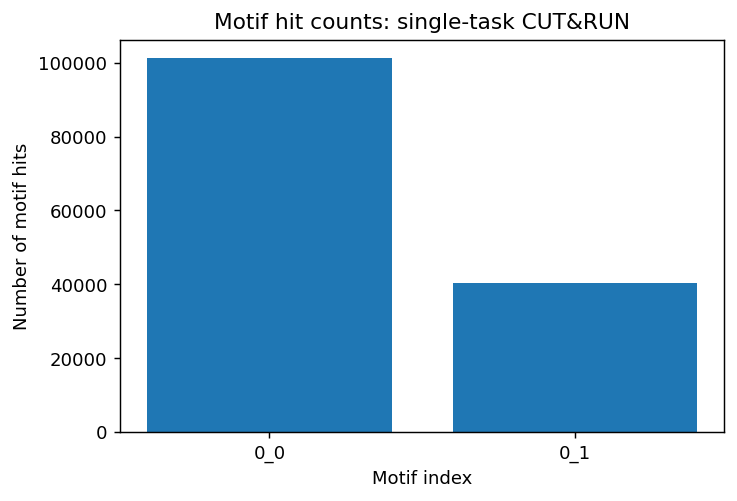

In [45]:
# motif hit counts bar plot for SINGLE task
plt.bar(pd.value_counts(hits_single.name).keys(), pd.value_counts(hits_single.name).values)
plt.xlabel('Motif index')
plt.ylabel('Number of motif hits')
plt.title('Motif hit counts: single-task CUT&RUN')

Text(0.5, 1.0, 'Motif hit counts: short task from multi-task CUT&RUN')

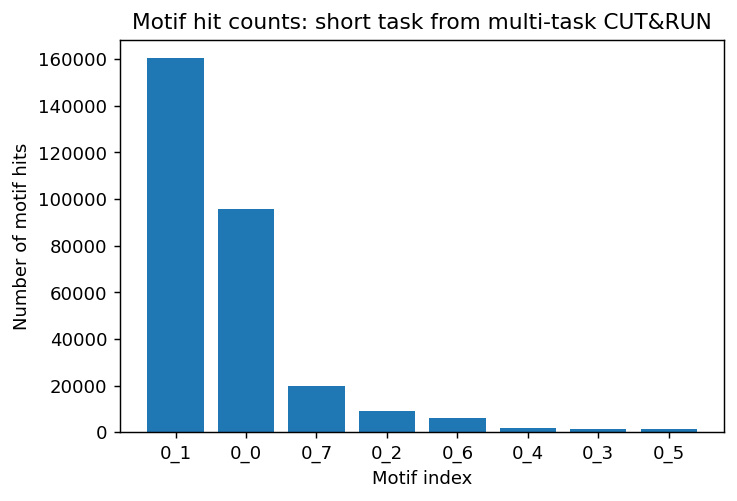

In [44]:
# motif hit counts bar plot for MAX task
fig = plt.plot(dpi=2000)
plt.bar(pd.value_counts(hits_max.name).keys(), pd.value_counts(hits_max.name).values)
plt.xlabel('Motif index')
plt.ylabel('Number of motif hits')
plt.title('Motif hit counts: short task from multi-task CUT&RUN')

Text(0.5, 1.0, 'Motif hit counts: long task from multi-task CUT&RUN')

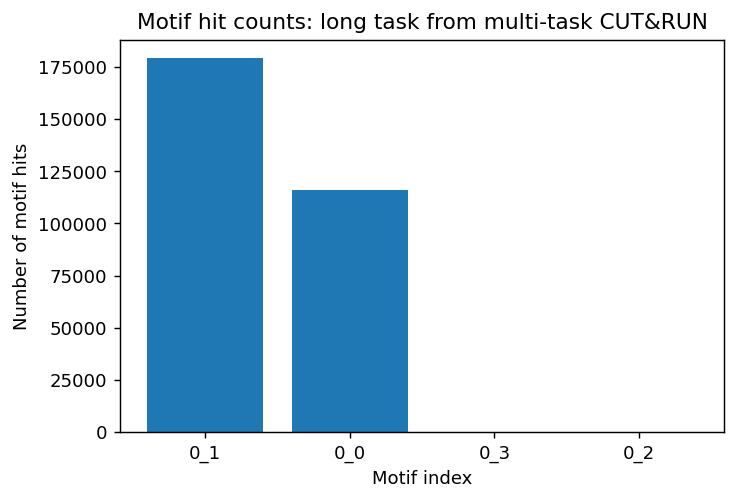

In [46]:
# motif hit counts bar plot for MIN task
plt.bar(pd.value_counts(hits_min.name).keys(), pd.value_counts(hits_min.name).values)
plt.xlabel('Motif index')
plt.ylabel('Number of motif hits')
plt.title('Motif hit counts: long task from multi-task CUT&RUN')

# Find a few locations where long or short task finds TA motif, but single task doesn’t. Show importance scores for these 3 tasks and the observed/predicted profiles.
## extra task after meeting Feb 9, 2022

In [17]:
# find motif hits unique to long/short task, where single-task doesn't see importance
#os.system('bedtools intersect -v -a /home/katie/bp_repo/reports/tfm_hits/CTCF/ctcf_maxfl120_feb7/tfm_matches.bed -b /home/katie/bp_repo/reports/tfm_hits/CTCF/ctcf_cutnrun_feb7/tfm_matches.bed > /home/katie/bp_repo/reports/katie_notebooks/TASK_1/unique_short_no_single')
#os.system('bedtools intersect -v -a /home/katie/bp_repo/reports/tfm_hits/CTCF/ctcf_minfl150_feb7/tfm_matches.bed -b /home/katie/bp_repo/reports/tfm_hits/CTCF/ctcf_cutnrun_feb7/tfm_matches.bed > /home/katie/bp_repo/reports/katie_notebooks/TASK_1/unique_long_no_single')

short_unique_hits = import_peak_table(['/home/katie/bp_repo/reports/katie_notebooks/TASK_1/unique_short_no_single']) # 161,418 hits
long_unique_hits = import_peak_table(['/home/katie/bp_repo/reports/katie_notebooks/TASK_1/unique_long_no_single'])   # 155,922 hits

# so about half of the hits for both short and long tasks are unique to them and don't overlap single-task hits
# but it is NOT true that every single-task hit overlaps a short/long hit, if you compare the numbers of motif hits 


In [48]:
# Plotting defaults
plot_params = {
    "figure.titlesize": 22,
    "axes.titlesize": 22,
    "axes.labelsize": 20,
    "legend.fontsize": 18,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "font.weight": "bold"
}
plt.rcParams.update(plot_params)

# Define constants
input_length, profile_length = 2114, 1000
shap_score_center_size = 400
profile_display_center_size = 400
hyp_score_key = "hyp_scores"
task_index = None

shap_scores_path_short, shap_scores_path_long = '/home/katie/bp_repo/pipeline_outputs/ctcf_cutnrun_120_150_feb7/shap_scores_CTCF_120','/home/katie/bp_repo/pipeline_outputs/ctcf_cutnrun_120_150_feb7/shap_scores_CTCF_150'



In [24]:
# Import SHAP coordinates and one-hot sequences
hyp_scores_short, _, one_hot_seqs_short, shap_coords_short = import_shap_scores(shap_scores_path_short, hyp_score_key, 
                                                              center_cut_size=shap_score_center_size, remove_non_acgt=False)
hyp_scores_long, _, one_hot_seqs_long, shap_coords_long = import_shap_scores(shap_scores_path_long, hyp_score_key, 
                                                              center_cut_size=shap_score_center_size, remove_non_acgt=False)
# This cuts the sequences/scores off just as how TF-MoDISco saw them, but the coordinates are uncut



Importing SHAP scores: 100%|██████████████████| 217/217 [00:03<00:00, 54.86it/s]


In [28]:
shap_coords_short.shape

(216908, 3)

In [29]:
shap_coords_short

array([['chr3', 93469548, 93471662],
       ['chr10', 101012109, 101014223],
       ['chr10', 97406381, 97408495],
       ...,
       ['chr20', 21378398, 21380512],
       ['chr7', 140658868, 140660982],
       ['chr8', 132904158, 132906272]], dtype=object)

In [33]:
# Import the set of all profiles and their coordinates
true_profs, pred_profs, all_pred_coords = import_profiles('/home/katie/bp_repo/pipeline_outputs/ctcf_cutnrun_120_150_feb7/preds')

Importing predictions:   0%|          | 0/217 [00:00<?, ?it/s]

In [38]:
hits_max.shape

(295274, 17)

In [43]:
all_pred_coords

array([['chr3', 93469548, 93471662],
       ['chr10', 101012109, 101014223],
       ['chr10', 97406381, 97408495],
       ...,
       ['chr20', 21378398, 21380512],
       ['chr7', 140658868, 140660982],
       ['chr8', 132904158, 132906272]], dtype=object)

In [47]:
all_pred_coords[:,2] - all_pred_coords[:,1]

array([2114, 2114, 2114, ..., 2114, 2114, 2114], dtype=object)

In [46]:
all_pred_coords.shape

(216908, 3)

In [42]:
pred_profs.shape

(216908, 2, 1000, 2)

In [27]:
hyp_scores_short.shape

(216908, 400, 4)